# Project 3: Classifier Comparison - Logistic Regression vs. Bayes Classifiers

### Question I: Train/Test Comparison Using All 4 Models

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split into training and test sets (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Scale the features for better performance, have zero mean and unit variance
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Create Gaussian Naive Bayes classifier (no shared covariance)
class GaussianNaiveBayes:
    def __init__(self):
        self.class_priors = None
        self.means = None
        self.vars = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        
        # Initialize parameters
        self.class_priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.vars = np.zeros((n_classes, n_features))
        
        # Calculate parameters for each class
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / n_samples
            self.means[i, :] = X_c.mean(axis=0)
            self.vars[i, :] = X_c.var(axis=0)
        
        return self
    
    def _calculate_likelihood(self, X):
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        likelihood = np.zeros((n_samples, n_classes))
        
        for i in range(n_classes):
            # Calculate Gaussian probability density for each feature independently
            # log probability to avoid numerical underflow
            log_probs = -0.5 * np.sum(
                np.log(2 * np.pi * self.vars[i, :]) + 
                ((X - self.means[i, :]) ** 2) / self.vars[i, :],
                axis=1
            )
            likelihood[:, i] = log_probs + np.log(self.class_priors[i])
        
        return likelihood
    
    def predict(self, X):
        return self.classes[np.argmax(self._calculate_likelihood(X), axis=1)]

# Create Gaussian Bayes classifier with full covariance (not shared)
class GaussianBayesFullCovariance:
    def __init__(self, shared_covariance=False):
        self.class_priors = None
        self.means = None
        self.covs = None
        self.shared_covariance = shared_covariance
        self.cov_shared = None
        self.classes = None
        self.precision_matrices = None
        self.log_det_covs = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        
        # Initialize parameters
        self.class_priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.covs = np.zeros((n_classes, n_features, n_features))
        self.precision_matrices = np.zeros((n_classes, n_features, n_features))
        self.log_det_covs = np.zeros(n_classes)
        
        # Calculate parameters for each class
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / n_samples
            self.means[i, :] = X_c.mean(axis=0)
            self.covs[i, :, :] = np.cov(X_c, rowvar=False)
            
            # Add small regularization to ensure positive definiteness
            self.covs[i, :, :] += 1e-6 * np.eye(n_features)
        
        # Calculate shared covariance 
        if self.shared_covariance:
            self.cov_shared = np.zeros((n_features, n_features))
            for i in range(n_classes):
                self.cov_shared += self.class_priors[i] * self.covs[i]
            
            # Precompute log determinant and precision matrix for shared covariance
            sign, logdet = np.linalg.slogdet(self.cov_shared)
            self.log_det_covs = np.ones(n_classes) * logdet
            self.precision_matrices = np.ones((n_classes, 1, 1)) * np.linalg.inv(self.cov_shared)
        else:
            # Precompute log determinants and precision matrices for each class
            for i in range(n_classes):
                sign, logdet = np.linalg.slogdet(self.covs[i])
                self.log_det_covs[i] = logdet
                self.precision_matrices[i] = np.linalg.inv(self.covs[i])
        
        return self
    
    def _calculate_likelihood(self, X):
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        likelihood = np.zeros((n_samples, n_classes))
        
        for i in range(n_classes):
            diff = X - self.means[i]
            
            # Use appropriate covariance
            if self.shared_covariance:
                precision = self.precision_matrices[0]
            else:
                precision = self.precision_matrices[i]
            
            # Calculate log likelihood
            log_likelihood = -0.5 * (
                self.log_det_covs[i] + 
                np.sum(np.matmul(diff, precision) * diff, axis=1)
            )
            likelihood[:, i] = log_likelihood + np.log(self.class_priors[i])
        
        return likelihood
    
    def predict(self, X):
        return self.classes[np.argmax(self._calculate_likelihood(X), axis=1)]

# Compare models on full training set
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Naive Bayes': GaussianNaiveBayes(),
    'Bayes Full Cov (Shared)': GaussianBayesFullCovariance(shared_covariance=True),
    'Bayes Full Cov (Not Shared)': GaussianBayesFullCovariance(shared_covariance=False)
}

# Train and evaluate each model
print("Part I: Model performance on full training set")
print("="*60)
print(f"{'Model':<25} {'Train Accuracy':<15} {'Test Accuracy':<15}")
print("-"*60)

for name, model in models.items():
    model.fit(X_train_full, y_train_full)
    
    # Calculate training accuracy
    y_train_pred = model.predict(X_train_full)
    train_accuracy = accuracy_score(y_train_full, y_train_pred)
    
    # Calculate test accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"{name:<25} {train_accuracy:.4f}        {test_accuracy:.4f}")



Part I: Model performance on full training set
Model                     Train Accuracy  Test Accuracy  
------------------------------------------------------------
Logistic Regression       0.9868        0.9737
Naive Bayes               0.9363        0.9649
Bayes Full Cov (Shared)   0.9648        0.9561
Bayes Full Cov (Not Shared) 0.9780        0.9561


### Question II: 	Training/Testing with Increasing Training Sizes

In [7]:
training_sizes = np.arange(5, 501, 5)
n_repetitions = 10

# Dictionaries to store results
train_accuracies = {name: np.zeros((len(training_sizes), n_repetitions)) for name in models.keys()}
test_accuracies = {name: np.zeros((len(training_sizes), n_repetitions)) for name in models.keys()}

# Function to ensure we get samples from both classes
def stratified_sample(X, y, n):
    classes = np.unique(y)
    indices = []
    
    # Calculate the target number per class
    target_per_class = n // len(classes)
    
    # For each class, select as many as possible up to the target
    for c in classes:
        class_indices = np.where(y == c)[0]
        # Take min of target and available
        n_to_select = min(target_per_class, len(class_indices))
        
        if n_to_select > 0:
            selected = np.random.choice(class_indices, size=n_to_select, replace=False)
            indices.extend(selected)
    
    # If we didn't get enough, randomly select more
    current_size = len(indices)
    if current_size < n:
        remaining = n - current_size
        
        # Get indices not yet selected
        all_indices = np.arange(len(y))
        eligible_indices = np.setdiff1d(all_indices, indices)
        
        # If there are enough eligible indices, take what we need
        if len(eligible_indices) >= remaining:
            additional = np.random.choice(eligible_indices, size=remaining, replace=False)
            indices.extend(additional)
        else:
            # Otherwise take all remaining eligible indices
            indices.extend(eligible_indices)
    
    return np.array(indices)

# Run experiment
for i, n in enumerate(training_sizes):
    for rep in range(n_repetitions):
        # Sample a stratified training set of size n
        indices = stratified_sample(X_train_full, y_train_full, n)
        X_train_subset = X_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Verify that we have at least two classes
        if len(np.unique(y_train_subset)) < 2:
            print(f"Warning: Only one class in sample for size {n}, repetition {rep}")
            continue
        
        # Train each model on the same training subset
        for name, model in models.items():
            model.fit(X_train_subset, y_train_subset)
            
            # Calculate training accuracy
            y_train_pred = model.predict(X_train_subset)
            train_accuracies[name][i, rep] = accuracy_score(y_train_subset, y_train_pred)
            
            # Calculate test accuracy
            y_test_pred = model.predict(X_test)
            test_accuracies[name][i, rep] = accuracy_score(y_test, y_test_pred)
    
    # Print progress
    if (i + 1) % 20 == 0:
        print(f"Completed {i+1}/{len(training_sizes)} training sizes")

# Calculate mean accuracies across repetitions
mean_train_accuracies = {name: np.mean(accs, axis=1) for name, accs in train_accuracies.items()}
mean_test_accuracies = {name: np.mean(accs, axis=1) for name, accs in test_accuracies.items()}

Completed 20/100 training sizes
Completed 40/100 training sizes
Completed 60/100 training sizes
Completed 80/100 training sizes
Completed 100/100 training sizes


### Question III: Create Plots

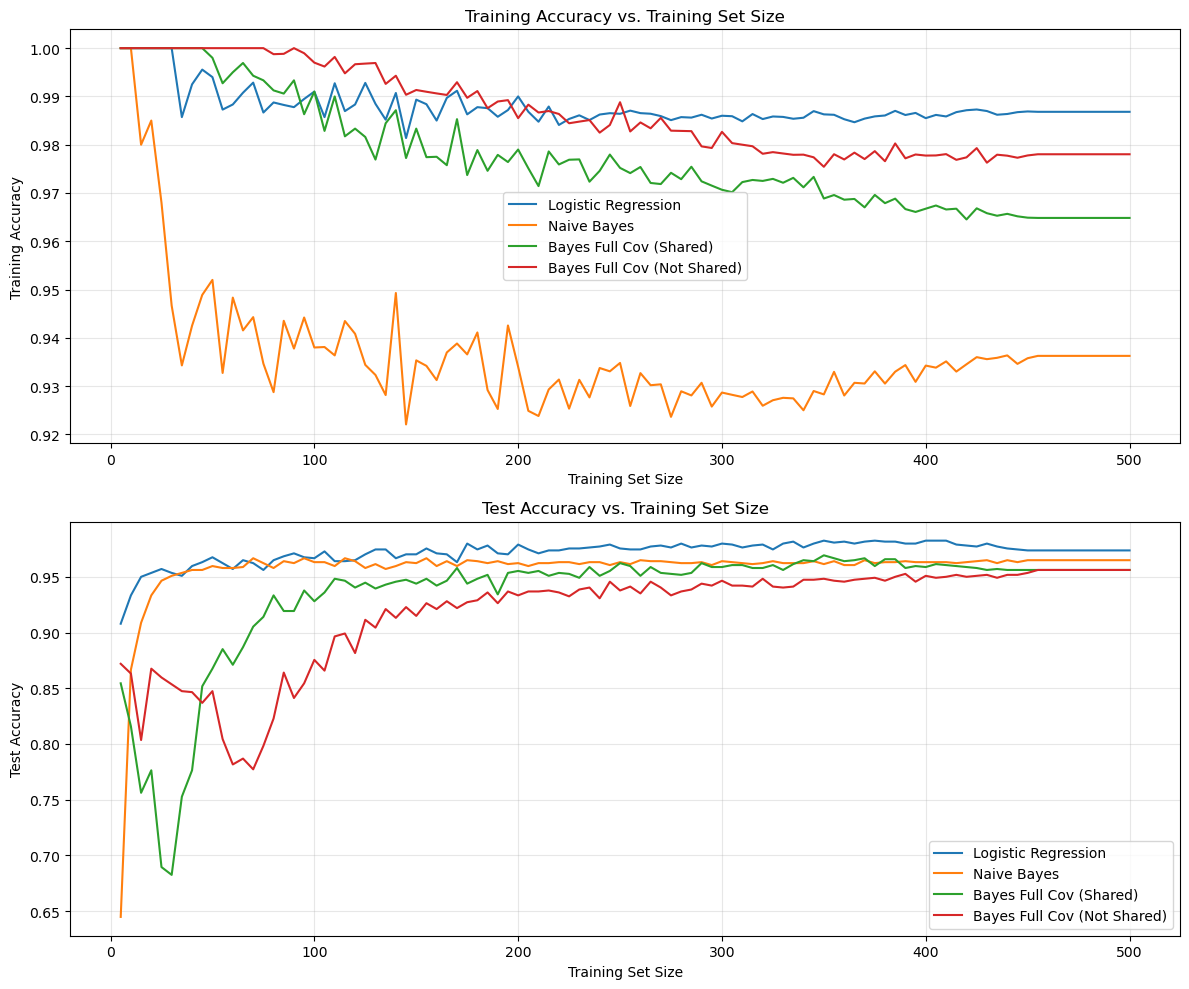

In [9]:
plt.figure(figsize=(12, 10))

# Plot training accuracies
plt.subplot(2, 1, 1)
for name, accuracies in mean_train_accuracies.items():
    plt.plot(training_sizes, accuracies, label=name)
plt.xlabel('Training Set Size')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Training Set Size')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot test accuracies
plt.subplot(2, 1, 2)
for name, accuracies in mean_test_accuracies.items():
    plt.plot(training_sizes, accuracies, label=name)
plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Training Set Size')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

### Question IV


#### a. What happens to each classifier's train and test performance when the number of training data points is increased?

**Logistic Regression:**
- **Training accuracy**: Starts very high (close to 100%) and gradually decreases slightly as more data points are added, stabilizing around 98.5-99%.
- **Test accuracy**: Rises quickly with small training sets and continues to improve gradually, eventually stabilizing around 97% with larger training sets.

**Naive Bayes:**
- **Training accuracy**: Initially very high with few samples, then drops significantly and stabilizes around 93-94%.
- **Test accuracy**: Improves rapidly with small training sets and stabilizes quickly around 95-96%.

**Bayes Full Covariance (Shared):**
- **Training accuracy**: Starts high and gradually decreases as more data is added, stabilizing around 96.5%.
- **Test accuracy**: Shows initial volatility with very small training sets, then improves steadily before stabilizing around 95.5%.

**Bayes Full Covariance (Not Shared):**
- **Training accuracy**: Starts highest among all models but shows the steepest decline as training data increases, stabilizing around 97.8%.
- **Test accuracy**: Shows the most volatility with small training sets, including the lowest performance at some points, before gradually improving and stabilizing around 95.5%.

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

**For small training sets:**
- **Logistic Regression** performs best overall, showing the highest test accuracy with very small training sets (5-50 samples).
- **Naive Bayes** also performs well with small datasets, showing quick convergence to good test accuracy.

**For large training sets:**
- All models eventually converge to similar test performance (95-97% accuracy).
- **Logistic Regression** maintains a slight edge in test accuracy even with large training sets.
- The performance gap between models narrows significantly as the training set size increases.

#### c. Justification of observations with possible reasons:

**Logistic Regression:**
- Performs well across all training sizes because it makes fewer assumptions about the data distribution.
- Has fewer parameters to learn compared to full covariance Bayesian models (only needs to learn weights for decision boundary).
- Shows good generalization even with small datasets, suggesting the decision boundary is relatively simple for this problem.
- The slight decrease in training accuracy with more data points indicates it's less prone to overfitting than the Bayesian models.

**Naive Bayes:**
- The significant gap between training and test accuracy indicates the independence assumption is violated (features in breast cancer data are likely correlated).
- Performs reasonably well with small datasets because the independence assumption provides a strong regularization effect.
- Has the fewest parameters to learn (just class priors and feature-wise means and variances), making it data-efficient.

**Bayes Full Covariance (Shared):**
- Initially struggles with very small datasets because it needs to estimate a full covariance matrix.
- Improves steadily as more data becomes available for better covariance estimation.
- The shared covariance assumption helps it generalize better with limited data compared to the non-shared version.

**Bayes Full Covariance (Not Shared):**
- Shows the highest training accuracy but initially poor test performance, indicating overfitting with small datasets.
- Has the most parameters to learn (separate covariance matrices for each class).
- Most vulnerable to small sample sizes because it needs sufficient data to estimate separate covariance matrices accurately.
- The high training accuracy reflects its flexibility to fit the training data precisely.

**Overall insights:**
1. Models with fewer parameters (Logistic Regression, Naive Bayes) perform better with limited data.
2. More complex models (Full Covariance Bayesian) require more data to estimate parameters accurately.
3. The bias-variance tradeoff is evident: simpler models have higher bias but lower variance (better with small datasets), while complex models have lower bias but higher variance (require more data to generalize well).
4. For this breast cancer dataset, the decision boundary appears to be relatively simple, allowing Logistic Regression to perform well even with limited data.